# Link Prediction on Node Pairs

## 1. Import required packages and define functions

In [5]:
import os
import math
import shutil
import random
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from tabulate import tabulate

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc


In [6]:
def show_graph_info(graph):
    # Compute the number of nodes and edges of the graph
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    # Compute in-degree and out-degree of each node
    in_degrees = dict(graph.in_degree())
    out_degrees = dict(graph.out_degree())
    # Compute average in-degree and out-degree
    avg_in_degree = sum(in_degrees.values()) / len(in_degrees)
    avg_out_degree = sum(out_degrees.values()) / len(out_degrees)
   # Create a table with the graph information
    table = [
        ["Number of nodes", num_nodes],
        ["Number of edges", num_edges],
        ["Average in-degree", f"{avg_in_degree:.2f}"],
        ["Average out-degree", f"{avg_out_degree:.2f}"]
    ]
    # Print the table
    print(tabulate(table, headers=["Metrices", "Value"]))


In [7]:
def add_missing_edges(df, num_missing_edges=12000, graph=None):
    """Adds missing edges to the given graph by randomly selecting node pairs 
    with no edges between them and adding them to a set. If the shortest path 
    length between the two nodes is greater than 2, the pair is added to a 
    dataframe and returned.

    Args:
        df (pandas.DataFrame): The input graph dataframe with columns 'node1', 'node2', and 'label'.
        num_missing_edges (int): The number of missing edges to generate. Default is 12000.
        G (networkx.Graph): The input graph. If not provided, a new graph is created using df.

    Returns:
        pandas.DataFrame: The input graph dataframe with missing edges added and labeled as 0.
    """
    # Create graph if not provided
    if graph is None:
        graph = nx.from_pandas_edgelist(df, 'node1', 'node2')

    # Generate missing edges from given graph
    # A key-value pair represents a pair of nodes, with the value indicating the link status
    # ('1' for linked and '-1' for unlinked).
    edges = {}

    # Loop through each row of the DataFrame
    for row in df.itertuples(index=False):
        # Add the edge to the dictionary
        edges[(row[0], row[1])] = 1

    # Create a set to add missing edges
    missing_edges = set([])

    while (len(missing_edges) < num_missing_edges):
        a = random.randint(1, 10230)
        b = random.randint(1, 10230)
        tmp = edges.get((a, b), -1)

        # Check if the edge between them is present in the dict
        # Also, chosen nodes can't be the same
        if tmp == -1 and a != b:
            try:
                # Adding points who less likely to be friends
                if nx.shortest_path_length(graph, source=a, target=b) > 2:
                    # If the shortest path between two nodes is greater than two, we add them to our missing set.
                    missing_edges.add((a, b))
                else:
                    continue
            except:
                missing_edges.add((a, b))
        else:
            continue

    df_missing_edges = pd.DataFrame(list(missing_edges), columns=['node1', 'node2'])
    df_missing_edges['label'] = 0
    df = pd.concat([df, df_missing_edges], ignore_index=True)

    return df

In [8]:
class feature_extractor():
    def __init__(self, df, graph):
        self.df = df
        # self.graph = self.get_graph()
        self.graph = graph
        self.wcc = list(nx.weakly_connected_components(self.graph))

    def get_graph(self):
        # Sample the edges
        tmp = self.df.copy()
        if {'label'}.issubset(tmp.columns):
            df_sample = tmp[tmp['label'] == 1]
        else:
            df_sample = tmp
        graph = nx.DiGraph()
        # Add edges to graph
        for i, row in df_sample.iterrows():
            graph.add_edge(row['node1'], row['node2'])
        return graph

    def get_features(self):
        df_tmp = self.df.copy()
        pr, mean_pr = self.get_pr()
        katz, mean_katz = self.get_katz()
        hubs, authorities = self.get_hits()
        
        dc = nx.degree_centrality(self.get_graph())
        bc = nx.betweenness_centrality(self.get_graph())
        cc = nx.clustering(self.get_graph())

        centrality_measures = [
            ('dc', dc),
            ('bc', bc),
            ('cc', cc)
        ]

        for col_name, metrics in centrality_measures:
            df_tmp[f'{col_name}_node1'] = df_tmp.apply(
                lambda row: metrics.get(row['node1'], 0), axis=1)
            
            df_tmp[f'{col_name}_node2'] = df_tmp.apply(
                lambda row: metrics.get(row['node2'], 0), axis=1)

        (df_tmp['num_followers_s'], df_tmp['num_followers_d'],
         df_tmp['num_followees_s'], df_tmp['num_followees_d'],
         df_tmp['inter_followers'], df_tmp['inter_followees']) = self.compute_features_stage1()


        # Define the column names and corresponding functions
        features_stage2 = [
            ('jaccard_followers', self.jaccard_for_followers),
            ('jaccard_followees', self.jaccard_for_followees),
            ('cosine_followers', self.cosine_for_followers),
            ('cosine_followees', self.cosine_for_followees),
            ('adar_index', self.calc_adar_in),
            ('follows_back', self.follows_back),
            ('same_comp', self.belongs_to_same_wcc),
            ('shortest_path', self.compute_shortest_path_length)
        ]

        # Apply the functions to the train and test dataframes
        for col_name, func in features_stage2:
            df_tmp[col_name] = df_tmp.apply(lambda row: func(
                row['node1'], row['node2']), axis=1)

        features_stage3 = {
            'page_rank': lambda x: pr.get(x, mean_pr),
            'katz': lambda x: katz.get(x, mean_katz),
            'hubs': lambda x: hubs.get(x, 0),
            'authorities': lambda x: authorities.get(x, 0)
        }

        # Apply each function to the source and destination nodes in the train and test dataframes
        for feature_name, feature_func in features_stage3.items():
            df_tmp[f'{feature_name}_s'] = df_tmp['node1'].apply(feature_func)
            df_tmp[f'{feature_name}_d'] = df_tmp['node2'].apply(feature_func)

        return df_tmp

    def compute_features_stage1(self):
        # calculating no of followers followees for source and destination
        # calculating intersection of followers and followees for source and destination
        num_followers_s = []
        num_followees_s = []
        num_followers_d = []
        num_followees_d = []
        inter_followers = []
        inter_followees = []

        for i, row in self.df.iterrows():
            s1 = set(self.graph.predecessors(row['node1'])) if self.graph.has_node(
                row['node1']) else set()
            s2 = set(self.graph.successors(row['node1'])) if self.graph.has_node(
                row['node1']) else set()
            d1 = set(self.graph.predecessors(row['node2'])) if self.graph.has_node(
                row['node2']) else set()
            d2 = set(self.graph.successors(row['node2'])) if self.graph.has_node(
                row['node2']) else set()

            num_followers_s.append(len(s1))
            num_followees_s.append(len(s2))
            num_followers_d.append(len(d1))
            num_followees_d.append(len(d2))
            inter_followers.append(len(s1.intersection(d1)))
            inter_followees.append(len(s2.intersection(d2)))

        return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

    # For followees
    def jaccard_for_followees(self, a, b):
        try:
            if len(set(self.graph.successors(a))) == 0 | len(set(self.graph.successors(b))) == 0:
                return 0
            sim = (len(set(self.graph.successors(a)).intersection(set(self.graph.successors(b))))) /\
                (len(set(self.graph.successors(a)).union(set(self.graph.successors(b)))))
        except:
            return 0
        return sim

    # For followers
    def jaccard_for_followers(self, a, b):
        try:
            if len(set(self.graph.predecessors(a))) == 0 | len(set(self.graph.predecessors(b))) == 0:
                return 0
            sim = (len(set(self.graph.predecessors(a)).intersection(set(self.graph.predecessors(b))))) /\
                (len(set(self.graph.predecessors(a)).union(
                    set(self.graph.predecessors(b)))))
            return sim
        except:
            return 0

    # For followees
    def cosine_for_followees(self, a, b):
        try:
            if len(set(self.graph.successors(a))) == 0 | len(set(self.graph.successors(b))) == 0:
                return 0
            sim = (len(set(self.graph.successors(a)).intersection(set(self.graph.successors(b))))) /\
                (math.sqrt(len(set(self.graph.successors(a)))
                           * len((set(self.graph.successors(b))))))
            return sim
        except:
            return 0

    # For followers
    def cosine_for_followers(self, a, b):
        try:
            if len(set(self.graph.predecessors(a))) == 0 | len(set(self.graph.predecessors(b))) == 0:
                return 0
            sim = (len(set(self.graph.predecessors(a)).intersection(set(self.graph.predecessors(b))))) /\
                (math.sqrt(len(set(self.graph.predecessors(a))))
                 * (len(set(self.graph.predecessors(b)))))
            return sim
        except:
            return 0

    # Adar Index
    def calc_adar_in(self, a, b):
        sum = 0
        try:
            n = list(set(self.graph.successors(a)).intersection(
                set(self.graph.successors(b))))
            if len(n) != 0:
                for i in n:
                    if (np.log10(len(list(self.graph.predecessors(i)))) == 0):
                        sum = sum+(1/1e-15)
                    else:
                        sum = sum + \
                            (1/np.log10(len(list(self.graph.predecessors(i)))))
                return sum
            else:
                return 0
        except:
            return 0

    # Follow Back
    def follows_back(self, a, b):
        if self.graph.has_edge(b, a):
            return 1
        else:
            return 0

    # Weakly connected components
    def belongs_to_same_wcc(self, a, b):
        index = []
        if self.graph.has_edge(b, a):
            return 1
        if self.graph.has_edge(a, b):
            for i in self.wcc:
                if a in i:
                    index = i
                    break
            if (b in index):
                self.graph.remove_edge(a, b)
                if self.compute_shortest_path_length(a, b) == -1:
                    self.graph.add_edge(a, b)
                    return 0
                else:
                    self.graph.add_edge(a, b)
                    return 1
            else:
                return 0
        else:
            for i in self.wcc:
                if a in i:
                    index = i
                    break
            if (b in index):
                return 1
            else:
                return 0

   # Shortest Path
    def compute_shortest_path_length(self, a, b):
        p = -1
        try:
            if self.graph.has_edge(a, b):
                self.graph.remove_edge(a, b)
                p = nx.shortest_path_length(self.graph, source=a, target=b)
                self.graph.add_edge(a, b)
            else:
                p = nx.shortest_path_length(self.graph, source=a, target=b)
            return p
        except:
            return -1

    # Page Rank
    def get_pr(self):
        pr = nx.pagerank(self.graph, alpha=0.85)
        mean_pr = float(sum(pr.values())) / len(pr)
        print('\nPage Rank')
        print('min', pr[min(pr, key=pr.get)])
        print('max', pr[max(pr, key=pr.get)])
        print('mean', float(sum(pr.values())) / len(pr))
        return pr, mean_pr

    # Katz Centrality
    def get_katz(self):
        katz = nx.katz.katz_centrality(self.graph, alpha=0.005, beta=1)
        mean_katz = float(sum(katz.values())) / len(katz)
        print('\nKatz Centrality')
        print('min', katz[min(katz, key=katz.get)])
        print('max', katz[max(katz, key=katz.get)])
        print('mean', float(sum(katz.values())) / len(katz))
        return katz, mean_katz

    # HITS
    def get_hits(self):
        hits = nx.hits(self.graph, max_iter=100, tol=1e-08,
                       nstart=None, normalized=True)
        print('\nHITS')
        print('min', hits[0][min(hits[0], key=hits[0].get)])
        print('max', hits[0][max(hits[0], key=hits[0].get)])
        print('mean', float(sum(hits[0].values())) / len(hits[0]))
        hubs, authorities = hits
        return hubs, authorities


In [9]:
# Define a custom PyTorch dataset for training data
class TrainData(Dataset):
    # Constructor method
    def __init__(self, X_data, y_data):
        # Initialize the input and output data
        self.X_data = X_data
        self.y_data = y_data
    
    # Method to get an item at a given index
    def __getitem__(self, index):
        # Return the input and output data at the given index
        return self.X_data[index], self.y_data[index]
    
    # Method to get the length of the dataset
    def __len__(self):
        # Return the length of the input data
        return len(self.X_data)


# Define a custom PyTorch dataset for test data
class TestData(Dataset):
    # Constructor method
    def __init__(self, X_data):
        # Initialize the input data
        self.X_data = X_data
    
    # Method to get an item at a given index
    def __getitem__(self, index):
        # Return the input data at the given index
        return self.X_data[index]
    
    # Method to get the length of the dataset
    def __len__(self):
        # Return the length of the input data
        return len(self.X_data)

## 2. Exploratory Data Analysis

1. Sample 50 edges

Metrices              Value
------------------  -------
Number of nodes       97
Number of edges       50
Average in-degree      0.52
Average out-degree     0.52


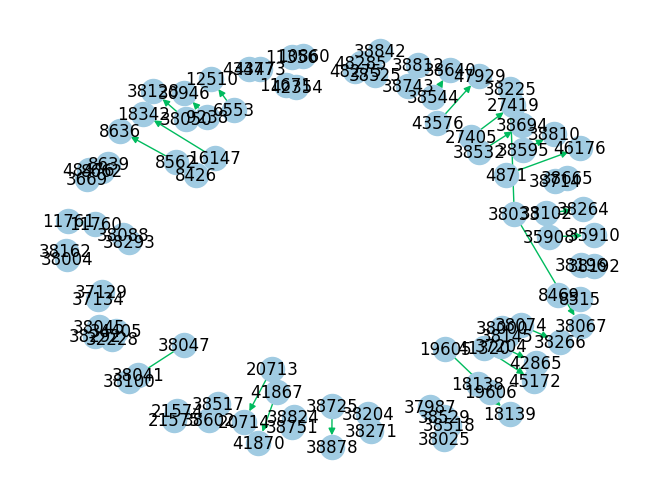

In [10]:
# creating a sample of 50 data points
df_sample_tmp = pd.read_csv('data/new_train_data.csv')
df_sample = df_sample_tmp[df_sample_tmp['label'] == 1][:50]
G_sample = nx.DiGraph()

for i, row in df_sample.iterrows():
    G_sample.add_edge(row['node1'], row['node2'], weight=row['label'])

# Plot and save the graph
pos = nx.spring_layout(G_sample)
nx.draw(G_sample, pos, node_color='#A0CBE2', edge_color='#00bb5e',
        width=1, edge_cmap=plt.cm.Blues, with_labels=True)
plt.savefig("imgs/G_sample.png")

show_graph_info(G_sample)


2. Plot the distribution of number of followers and followees of each node in the training set.

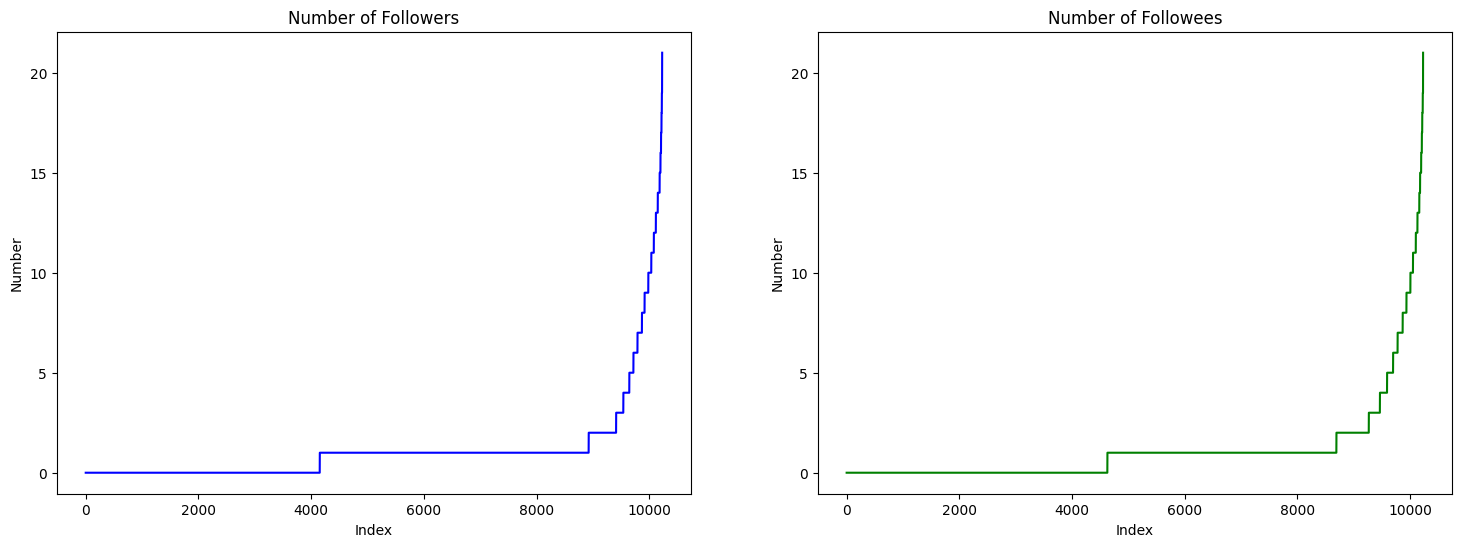

In [11]:
# Load the training dataset
df = pd.read_csv('data/new_train_data.csv')
# Generate the graph with node pairs with label == 1
G = nx.from_pandas_edgelist(df[df['label'] == 1], "node1", "node2", create_using=nx.DiGraph())

indegree_dist = list(dict(G.in_degree()).values())
indegree_dist.sort()
outdegree_dist = list(dict(G.out_degree()).values())
outdegree_dist.sort()

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Set the title for each subplot
ax1.set_title('Number of Followers')
ax2.set_title('Number of Followees')

# Plot the data on each subplot
ax1.plot(indegree_dist, color='blue')
ax2.plot(outdegree_dist, color='green')

# Set the x-axis and y-axis labels
ax1.set_xlabel('Index')
ax1.set_ylabel('Number')
ax2.set_xlabel('Index')
ax2.set_ylabel('Number')

# Show the plot
plt.show()


3. Obervation of Percentile

In [12]:
table_data = []

for i in range(0, 11):
    table_data.append([
        f'{90+i}%',
        np.percentile(indegree_dist, 90+i),
        np.percentile(outdegree_dist, 90+i),
        f'{99+i/10}%',
        np.percentile(indegree_dist, 99+i/10),
        np.percentile(outdegree_dist, 99+i/10)
    ])

print(tabulate(table_data, headers=[
      'Percentile', 'In-Degree', 'Out-Degree']*2))

# Compute the number of persons not following anyone and with no followers
no_following = sum(np.array(outdegree_dist) == 0)
no_followers = sum(np.array(indegree_dist) == 0)
total = len(outdegree_dist)

# Create a list of lists to store the data
table_data = [
    ['Number of persons not following anyone:',
        no_following, f'{no_following/total:.2%}'],
    ['Number of persons with no followers:',
        no_followers, f'{no_followers/total:.2%}'],
]

print("\n")

# Print the table
print(tabulate(table_data, headers=['Metrics', 'Value', '%']))


Percentile      In-Degree    Out-Degree  Percentile      In-Degree    Out-Degree
------------  -----------  ------------  ------------  -----------  ------------
90%                     2             2  99.0%              13                12
91%                     2             3  99.1%              13                13
92%                     2             3  99.2%              13                13
93%                     3             4  99.3%              14                13
94%                     4             5  99.4%              14                14
95%                     5             6  99.5%              14                15
96%                     7             7  99.6%              15                15
97%                     9             8  99.7%              15.313            16
98%                    10            10  99.8%              16.542            17
99%                    13            12  99.9%              18                18
100%                   21   

4. Count the number of friends the users have

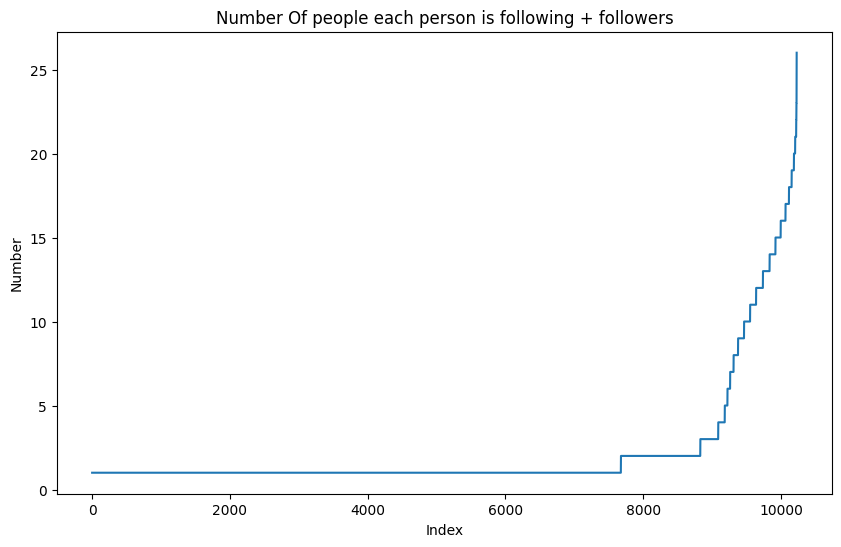

In [13]:
# Convert the lists to numpy arrays
in_degree = np.array(list(dict(G.in_degree()).values()))
out_degree = np.array(list(dict(G.out_degree()).values()))
# Add the arrays element-wise
in_out_degree = in_degree + out_degree
# Convert the in_out_degree back to a list
in_out_degree = sorted(in_out_degree.tolist())
plt.figure(figsize=(10, 6))
plt.plot(in_out_degree)
plt.title("Number Of people each person is following + followers")
plt.xlabel('Index')
plt.ylabel('Number')
plt.show()


## 3. Data Preparation

1. Load node pairs and generate the graph

In [14]:
# Load the training dataset
df = pd.read_csv('data/new_train_data.csv')
# Generate the graph with node pairs with label == 1
G = nx.from_pandas_edgelist(df[df['label'] == 1], "node1", "node2", create_using=nx.DiGraph())
# Check the number of nodes and edges in the original dataset
show_graph_info(G)

Metrices               Value
------------------  --------
Number of nodes     10230
Number of edges     12000
Average in-degree       1.17
Average out-degree      1.17


2. Generating missing edges from given graph

In [15]:
df = add_missing_edges(df, num_missing_edges=G.number_of_edges(), graph=G)

3. Split the dataset into training and testing sets

In [16]:
# Split the dataset into training and testing sets
df_train, df_test = train_test_split(df, test_size=0.2)

4. Extract the features from datasets

In [17]:
df_train_obj = feature_extractor(df_train, G)
show_graph_info(df_train_obj.graph)
df_train = df_train_obj.get_features()

df_test_obj = feature_extractor(df_test, G)
show_graph_info(df_test_obj.graph)
df_test = df_test_obj.get_features()

df_train


Metrices               Value
------------------  --------
Number of nodes     10230
Number of edges     12000
Average in-degree       1.17
Average out-degree      1.17

Page Rank
min 6.065400513331147e-05
max 0.0018194200713379078
mean 9.775171065495381e-05

Katz Centrality
min 0.00982796012312409
max 0.010901384596002185
mean 0.009886280671533283

HITS
min -1.7618769405953595e-17
max 0.008046458171009348
mean 9.77517106549364e-05
Metrices               Value
------------------  --------
Number of nodes     10230
Number of edges      3677
Average in-degree       0.36
Average out-degree      0.36

Page Rank
min 8.29698955442808e-05
max 0.001839267502727833
mean 9.775171065492952e-05

Katz Centrality
min 0.009868964316104964
max 0.010617580772405804
mean 0.009886773614925

HITS
min -2.600048224814777e-18
max 0.018545559636669914
mean 9.775171065493633e-05


,node1,node2,label,dc_node1,dc_node2,bc_node1,bc_node2,cc_node1,cc_node2,num_followers_s,...,same_comp,shortest_path,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d
30703,1291,1133,0,0.000230,0.000345,1.322851e-08,0.000000e+00,0.000000,0.000000,1,...,0,-1,0.000087,0.000061,0.009877,0.009828,1.323249e-21,2.763389e-19,-1.224359e-18,2.263568e-19
17758,38852,38292,0,0.001265,0.001380,2.161076e-06,8.813936e-07,0.036364,0.022727,13,...,0,-1,0.000578,0.000868,0.010491,0.010692,1.036060e-03,6.627828e-19,3.491254e-03,-2.635451e-18
14448,38606,38788,1,0.002645,0.001265,6.956876e-06,1.977520e-06,0.003953,0.000000,7,...,1,4,0.000089,0.000210,0.010175,0.010385,6.983598e-03,2.447018e-03,3.196880e-03,3.479921e-03
3744,38143,38304,1,0.001725,0.001495,5.381769e-06,0.000000e+00,0.019048,0.019231,8,...,1,3,0.000098,0.000756,0.010227,0.010591,1.793227e-18,-0.000000e+00,1.605446e-17,8.289019e-19
22356,38749,38802,1,0.001265,0.002070,3.026935e-06,1.854969e-05,0.018182,0.009804,9,...,0,-1,0.000133,0.000397,0.010279,0.010537,2.674624e-03,1.904141e-03,3.813634e-03,4.814669e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5694,5598,37516,1,0.000345,0.000115,0.000000e+00,0.000000e+00,0.000000,0.000000,0,...,0,-1,0.000061,0.000078,0.009828,0.009877,-2.342916e-19,-0.000000e+00,2.617332e-19,-1.503146e-18
19274,12339,30361,0,0.000000,0.000115,0.000000e+00,0.000000e+00,0.000000,0.000000,0,...,0,-1,0.000061,0.000113,0.009828,0.009877,2.925736e-21,-0.000000e+00,6.425157e-19,-4.238389e-20
33440,9838,5582,0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0,...,0,-1,0.000098,0.000098,0.009886,0.009886,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
6953,5331,33980,0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0,...,0,-1,0.000061,0.000098,0.009828,0.009886,-1.980973e-21,0.000000e+00,-9.322708e-19,0.000000e+00


5. Plot the distribution of data

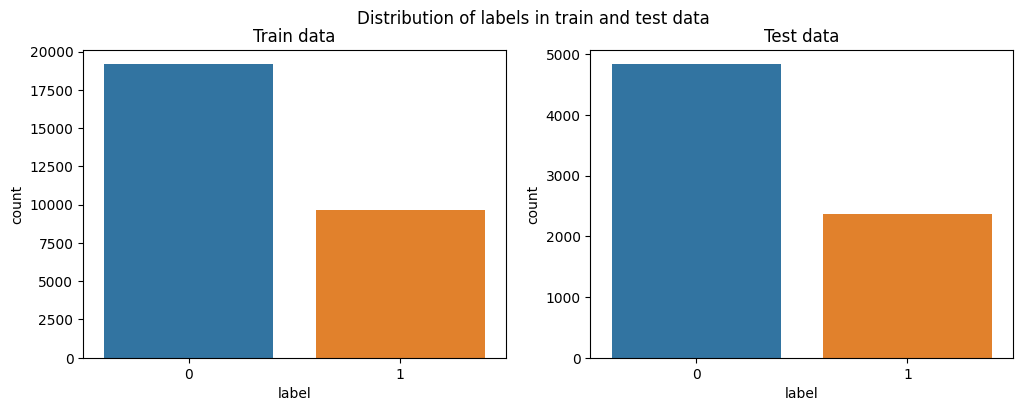

In [18]:
# Create a figure with two subplots
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

# Plot the countplots
sns.countplot(x='label', data=df_train, ax=axs[0])
sns.countplot(x='label', data=df_test, ax=axs[1])

# Set the titles
axs[0].set_title('Train data')
axs[1].set_title('Test data')

# Add a title for the entire plot
fig.suptitle('Distribution of labels in train and test data')

# Display the plot
plt.show()

6. Prepare the dataset to train the model

In [19]:
# Slice the features from the dataframe
X_train = df_train.iloc[:, 3:]
X_test = df_test.iloc[:, 3:]
# Slice the label from the dataframe
y_train = df_train.iloc[:, 2]
y_test = df_test.iloc[:, 2]

# Standardize the data values into a standard format
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

train_data = TrainData(torch.FloatTensor(X_train),
                       torch.FloatTensor(y_train))
test_data = TestData(torch.FloatTensor(X_test))

7. Check the distribution of the dataset

In [20]:
# Count the number of label of 0 and 1
train_bincounts = np.bincount(df_train.iloc[:, 2])
test_bincounts = np.bincount(df_test.iloc[:, 2])

# Create a table with label and counts
table = [["Label 0", train_bincounts[0], test_bincounts[0]],
         ["Label 1", train_bincounts[1], test_bincounts[1]]]

# print the table using tabulate
print(tabulate(table, headers=["Label", "Train Count", "Test Count"]))

Label      Train Count    Test Count
-------  -------------  ------------
Label 0          19169          4831
Label 1           9631          2369


## 3. Build The Model

1. Build binary classification model

In [21]:
class BinaryClassification(nn.Module):
    # Initializing the neural network
    def __init__(self, input_shape):
        super(BinaryClassification, self).__init__()
        # Defining the neural network layers
        self.layer_1 = nn.Linear(input_shape, 64)
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1)

        # Defining activation functions and other layers
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)

    # Defining forward propagation
    def forward(self, inputs):
        # Feeding the inputs to the layers and passing them through activation functions and other layers
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)

        # Returning the output
        return x

2. Define the binary accuracy function

In [22]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)

    return acc

3. Add hyperparameters

In [23]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

4. Initialize the model, and create a loss function and optimizer

In [24]:
model = BinaryClassification(input_shape=X_train.shape[1])
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
model.to(device)

print(f'device: {device}')
print(f'model: {model}')

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

device: mps
model: BinaryClassification(
  (layer_1): Linear(in_features=28, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


5. Prepare the dataset with DataLoader

In [25]:
train_loader = DataLoader(
    dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

6. Train the model

In [26]:
model.train()

for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        y_pred = model(X_batch)

        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')


Epoch 001: | Loss: 0.32047 | Acc: 87.056
Epoch 002: | Loss: 0.22929 | Acc: 90.667
Epoch 003: | Loss: 0.21286 | Acc: 91.596
Epoch 004: | Loss: 0.19826 | Acc: 92.038
Epoch 005: | Loss: 0.19384 | Acc: 92.409
Epoch 006: | Loss: 0.18568 | Acc: 92.736
Epoch 007: | Loss: 0.18408 | Acc: 92.800
Epoch 008: | Loss: 0.17899 | Acc: 93.209
Epoch 009: | Loss: 0.17789 | Acc: 93.038
Epoch 010: | Loss: 0.17879 | Acc: 93.049
Epoch 011: | Loss: 0.17437 | Acc: 93.271
Epoch 012: | Loss: 0.17375 | Acc: 93.373
Epoch 013: | Loss: 0.17308 | Acc: 93.444
Epoch 014: | Loss: 0.16931 | Acc: 93.544
Epoch 015: | Loss: 0.16893 | Acc: 93.518
Epoch 016: | Loss: 0.16672 | Acc: 93.567
Epoch 017: | Loss: 0.16642 | Acc: 93.669
Epoch 018: | Loss: 0.16701 | Acc: 93.589
Epoch 019: | Loss: 0.16745 | Acc: 93.598
Epoch 020: | Loss: 0.16398 | Acc: 93.713
Epoch 021: | Loss: 0.16272 | Acc: 93.691
Epoch 022: | Loss: 0.16497 | Acc: 93.629
Epoch 023: | Loss: 0.16268 | Acc: 93.749
Epoch 024: | Loss: 0.16053 | Acc: 93.760
Epoch 025: | Los

7. Evaluation

In [27]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]


8. Check the confusion matrix and classification report

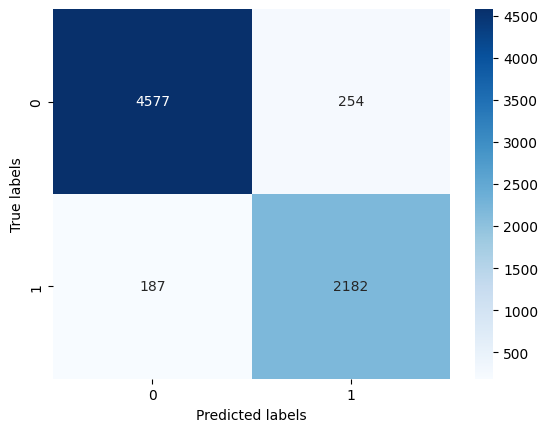

In [28]:
# assume the confusion matrix is stored in a variable called cm
cm = confusion_matrix(y_test, y_pred_list)

# create a heatmap using seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt="d")

# add labels to the plot
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [29]:
report = classification_report(y_test, y_pred_list, output_dict=False)

print(report)

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      4831
           1       0.90      0.92      0.91      2369

    accuracy                           0.94      7200
   macro avg       0.93      0.93      0.93      7200
weighted avg       0.94      0.94      0.94      7200



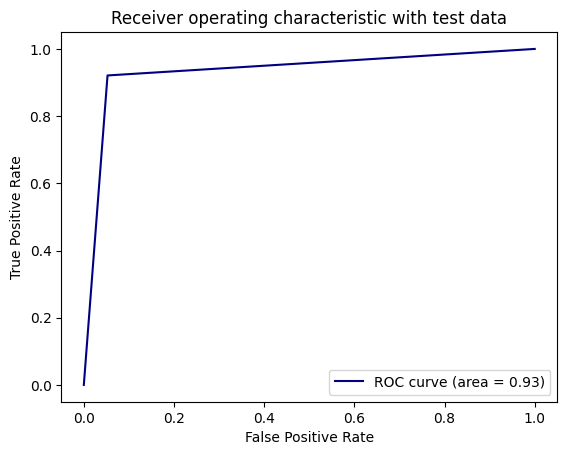

In [30]:
fpr, tpr, ths = roc_curve(y_test, y_pred_list)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy', label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

## 4. Make inferences on the public testing set

In [31]:
df_target = pd.read_csv('data/new_test_data.csv')
df_target_obj = feature_extractor(df_target, G)
show_graph_info(df_target_obj.graph)
df_target = df_target_obj.get_features()

X_target = df_target.iloc[:, 3:]

scaler = StandardScaler()
X_target = scaler.fit_transform(X_target)

target_data = TestData(torch.FloatTensor(X_target))

test_loader = DataLoader(dataset=target_data, batch_size=1)
y_pred_list = []

model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_pred_list = [int(f) for f in y_pred_list]
print(np.bincount(y_pred_list))

target_csv = 'data/sample_submit.csv'

# Load the CSV file into a Pandas DataFrame
df_target = pd.read_csv(target_csv)

# Replace the values in the 'ans' column with the values from the Python list
df_target['ans'] = y_pred_list

# Save the updated DataFrame back to a CSV file, overwriting the original file
df_target.to_csv(target_csv, index=False)


Metrices               Value
------------------  --------
Number of nodes     10230
Number of edges      1330
Average in-degree       0.13
Average out-degree      0.13

Page Rank
min 9.347823506612859e-05
max 0.0007019301261338533
mean 9.775171065491983e-05

Katz Centrality
min 0.009880448758297196
max 0.010425602518536243
mean 0.009886879863194788

HITS
min -1.9672083197500337e-16
max 0.032252844506932624
mean 9.77517106549366e-05
[4695 1305]
